# Classificando notícias com RNN

Temos desafio de organizar notícias, de acordo com o tema, contexto, sentimento.

"Pela quarta rodada do Campeonato Italiano, a Roma não tomou conhecimento do Empoli neste domingo e venceu pela primeira vez na competição."

Com base nesse contexto, poderiamos classificar essa notícia como do tipo "Esportes", certo? E por que sabemos disso? Bem, podemos observar algumas palavrinhas chaves tal como "campeonato" e "competição".

Vamos usar RNNs para realizar esta tarefa, analisar notícias e classificá-las com base em palavras-chaves. 

**Redes Neuras Recorrentes** têm a capacidade de aprender não só com os dados de entrada, mas com seus próprios outputs, ou seja, ocorre um loop de aprendizado.

# Importando bibliotecas

In [ ]:
!pip install nltk
!pip install wordcloud

: 

In [1]:
# Básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para NLP
import re, nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Jackson
[nltk_data]     Simionato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Lendo e explorando dados

In [2]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/5b00193e34c5955ba16b315efe415119fdce3bce/Aula%204%20-%20Redes%20Neurais%20Recorrentes/bbc-text.csv')

In [3]:
# DF com label e texto
df= raw_df.copy()
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [4]:
# Categorias presentes no DF. Problema de multiclasse.
df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [5]:
# Não há dados faltantes
df.isna().sum()

category    0
text        0
dtype: int64

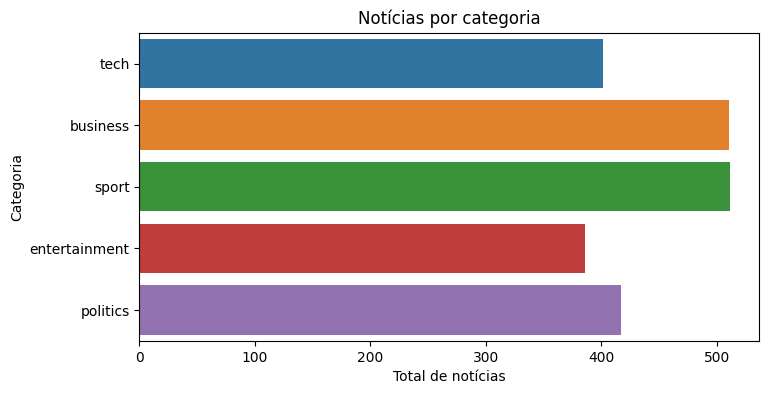

In [6]:
# Plot de notícias por categoria. Não há desequilíbrio entre as classes
fig, ax = plt.subplots(figsize=(8, 4))

sns.countplot(df, y='category', hue='category',ax=ax)

ax.set_xlabel('Total de notícias')
ax.set_ylabel('Categoria')
ax.set_title('Notícias por categoria')

plt.show()

# Pré-processamento de texto

Há uma grande diferença entre modelos que trabalham com texto e os modelos de ML convencionais. Um ML padrão possui dados numéricos bem estruturados em colunas e linhas. 

Já ao trabalhar com textos, as próprias palavras devem ser tratadas como variáveis ou propriedades do dado. Para simular isso, processos como a **tokenização**, o One-Hot encoding, o Pad sequencing e a camada Embedding Layer são utilizados

- Tokenization (separar o texto em "tokens", ou seja, separar parte por parte).
- One-Hot encoding (representar variáveis categóricas como vetores binários).
- Pad sequencing (Garante sequências de comprimento uniforme adicionando zeros nas sequencias de palavas para manter sequencias uniformes)
- Embedding layer (Word2Vec) (mapear palavras em vetores)

## Limpeza

Como primeiro passo, é necessário aplicar tecnicas para limpar e padronizar o texto, aplicando REGEX, removendo stop words e lematização (unificar palavras conjugadas de maneira diferente). 

### REGEX

FOrma flexível de identificar uma determinada sequencia de caracteres. Uma cadeia pode ser um caractere específico, uma palavra ou um padrão. No Python, o módulo re provê um analisador sintático que permite o uso de tais expressões. Os padrões definidos através de caracteres que tem significado especial para o analisador.

### Stop words

Busca descartar palavras como artigos e conjunções que não trazem significado para o texto. Ex: 'the', 'is', 'a'

### Lematização

Basicamente é um processo que determina uma única “raiz” para a palavra, independente de suas diferenças superficiais.

In [7]:
def limpeza_texto(text):
    # REGEX
    whitespace = re.compile(r"\s+") # Identifica espaços em branco
    user_mention = re.compile(r"(?i)@[a-z0-9_]+") # Identifica menções a usuarios com @
    text = whitespace.sub(' ', text) # Remove espaços em branco
    text = user_mention.sub('',text) # Remove menções a usuarios
    text = re.sub(r"\[[^()]*\]","", text)                      # remove o conteúdo dentro de colchetes, incluindo os colchetes
    text = re.sub("\d+", "", text)  # Remove digitos numéricos
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)","", text) # Remove menções de usário, urls, hashtags
    text = re.sub("[^\w\s]", "", text) # Remove caracteres que não palavras, caracteres especiais
    text = text.lower() # Converte para minúsculo

    # Removendo stopwords
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # Word lemmatization, mudançar para verbos no infinitivo
    sentence = []

    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [8]:
print(f'Texto antes da função: {df["text"][0]}')
print('\n')
print(f'Texto após a função: {limpeza_texto(df["text"][0])}')

Texto antes da função: tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also 

In [9]:
limpeza_texto('One god may be enough, but one for each person is the goal')

'one god may enough one person goal'

## Aplicando função

In [10]:
df['text_norm'] = df['text'].apply(limpeza_texto)

In [11]:
df.head()

,category,text,text_norm
0,tech,tv future in the hands of viewers with home th...,tv future hand viewers home theatre systems pl...
1,business,worldcom boss left books alone former worldc...,worldcom boss leave book alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say will ...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raid box office ocean s twelve ...


In [12]:
print(f"N caracteres antes da limpeza: {df['text'].apply(len).sum()}")
print(f"N caracteres após limpeza: {df['text_norm'].apply(len).sum()}")

N caracteres antes da limpeza: 5035033
N caracteres após limpeza: 3280708


# Tokenização e vetorização

Conversão de frases em palavras, necessário para identificar cada uma das palavras na base. Além disso cada palavra pode ser identificado por um número ou índice.

In [13]:
samples = list(df['text_norm'][:5].values)
samples

['tv future hand viewers home theatre systems plasma highdefinition tvs digital video recorders move live room way people watch tv will radically different five years time accord expert panel gather annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes us lead trend program content will deliver viewers via home network cable satellite telecoms company broadband service providers front room portable devices one talkedabout technologies ces digital personal video recorders dvr pvr settop box us s tivo uk s sky system allow people record store play pause forward wind tv program want essentially technology allow much personalise tv builtin highdefinition tv set big business japan us slower take europe lack highdefinition program people forward wind advert forget abide network channel schedule put together alacarte entertainment us network cable satellite company worry mean term advertise revenues well brand identity viewer loyalty channel al

In [14]:
token_index = {}

# For para guardar um índice numérico para cada palavra existente
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

# Valor máximo para sequencia. Palavras maiores serão truncadas
max_length = 15

results = np.zeros(shape=(len(samples),
                   max_length,
                   max(token_index.values())+1))

print(results.shape)
print(token_index)

# Criando matriz one hot encoding
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

(5, 15, 680)
{'tv': 1, 'future': 2, 'hand': 3, 'viewers': 4, 'home': 5, 'theatre': 6, 'systems': 7, 'plasma': 8, 'highdefinition': 9, 'tvs': 10, 'digital': 11, 'video': 12, 'recorders': 13, 'move': 14, 'live': 15, 'room': 16, 'way': 17, 'people': 18, 'watch': 19, 'will': 20, 'radically': 21, 'different': 22, 'five': 23, 'years': 24, 'time': 25, 'accord': 26, 'expert': 27, 'panel': 28, 'gather': 29, 'annual': 30, 'consumer': 31, 'electronics': 32, 'show': 33, 'las': 34, 'vegas': 35, 'discuss': 36, 'new': 37, 'technologies': 38, 'impact': 39, 'one': 40, 'favourite': 41, 'pastimes': 42, 'us': 43, 'lead': 44, 'trend': 45, 'program': 46, 'content': 47, 'deliver': 48, 'via': 49, 'network': 50, 'cable': 51, 'satellite': 52, 'telecoms': 53, 'company': 54, 'broadband': 55, 'service': 56, 'providers': 57, 'front': 58, 'portable': 59, 'devices': 60, 'talkedabout': 61, 'ces': 62, 'personal': 63, 'dvr': 64, 'pvr': 65, 'settop': 66, 'box': 67, 's': 68, 'tivo': 69, 'uk': 70, 'sky': 71, 'system': 72, 

## Aplicando Label Encoder

In [15]:
X = df['text_norm']
encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

In [16]:
print(X.shape)
print(y.shape)

(2225,)
(2225,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
tokenizer = Tokenizer(num_words=1000, oov_token='<00V>') # OOV = out of vocabulary
tokenizer.fit_on_texts(X_train) # Construindo indice de palavras

In [19]:
# Preenchimento dados de entrada de texto X_train

##converte strings em listas inteiras
train_seq = tokenizer.texts_to_sequences(X_train)

# Preenche listas de inteiros para o tensor de inteiros 2D. Padding para equiparar tamanho dos elementos
train_padseq = pad_sequences(train_seq, maxlen=200)

In [20]:
# Preenchimento dados de entrada de texto X_test

text_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(text_seq, maxlen=200)

In [21]:
word_index = tokenizer.word_index

# Número total de palavras a serem consideradas na camada de incorporação
max_words = 1500

total_words = len(word_index)
# Comprimento máximo da sequencia
maxlen = 200

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
print(f'Tamanho do índice de palavras: {total_words}')

Tamanho do índice de palavras: 22759


# Word embeddings

Consiste em transformar palavras emvetores. Grau de semelhança contexto entre uma classe e uma palavra. Como capturar o significado de uma frase?

O que é a técnica de word embeddings?

Essa técnica consiste em transformar palavras em vetores, permitindo que o computador processe o significado semântico das palavras. Esses vetores numéricos representam a semântica da palavra com base em sua relação com outras palavras em um corpus de treinamento. Palavras semanticamente semelhantes têm vetores de embedding semelhantes.

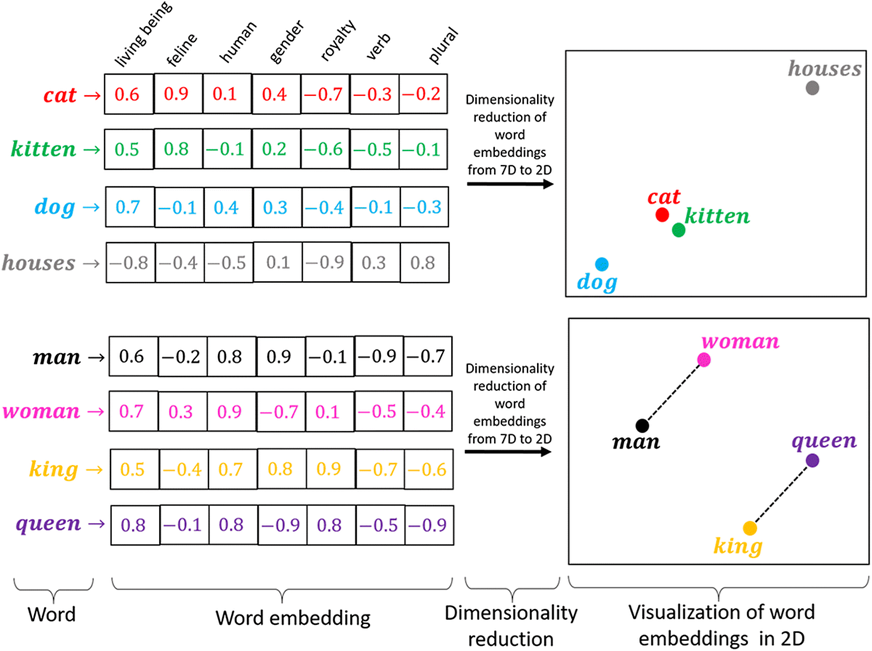

Os embeddings de palavras são uma alternativa à codificação one-hot juntamente com a redução da dimensionalidade

A biblioteca Keras possui uma camada de embeddings que representa palavras de um determinado corpus de texto.

tf.keras.layers.Embedding( input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None, kwargs )

Argumentos principais:

input_dim - Tamanho do vocabulário - comprimento do índice da palavra

output_dim - Dimensão de saída da representação da palavra

comprimento de entrada - comprimento máximo da sequência de entrada do documento

# Aplicando RNN

RNN = rede numérica com loop interno

In [22]:
# Definindo seed
tf.random.set_seed(44)

model = Sequential()

# Camada embedding utilizando parametros com total de palaras e tamanho máximo de cada palavra
model.add(Embedding(total_words, 70, input_length=maxlen))

# Camadas bidirecionais. Análise do contexto tanto de frente para trás como de trás para frente. Return sequences -> retorno de sequencias ao invés de um unico vetor
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.2, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.3, activation='tanh', return_sequences=True)))

model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
# 5 = 5 variáveis categóricas
model.add(Dense(5, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 70)           1593130   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          17280     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 128)          24704     
 onal)                                                           
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [23]:
# Adam = algoritmo de otimização, loss = função de perda a ser minimizada pelo algoritmo, metrics = métrica para monitorar durante o treinamento
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Config early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Métrica para monitorar early stopping
                                              patience=3,
                                              verbose=1, # Mostra mensagens de progresso durante treinamento
                                              mode='min') # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"

# Salvando modelo com melhores valores encontrados
checkpointer = ModelCheckpoint(filepath='bestbalue', monitor='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# Treinando modelo
history = model.fit(train_padseq, y_train, batch_size=120, epochs=15, validation_split=0.2)

#Validando modelo
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print('Test loss and accuracy:',test_loss, test_acc)

Epoch 1/15


12/12 [==============================] - 15s 854ms/step - loss: 1.7970 - accuracy: 0.2177 - val_loss: 1.6604 - val_accuracy: 0.2331
Epoch 2/15
12/12 [==============================] - 8s 683ms/step - loss: 1.7879 - accuracy: 0.2065 - val_loss: 1.6390 - val_accuracy: 0.2500
Epoch 3/15
12/12 [==============================] - 8s 656ms/step - loss: 1.7485 - accuracy: 0.2093 - val_loss: 1.6231 - val_accuracy: 0.2500
Epoch 4/15
12/12 [==============================] - 8s 697ms/step - loss: 1.7091 - accuracy: 0.2163 - val_loss: 1.6367 - val_accuracy: 0.2416
Epoch 5/15
12/12 [==============================] - 8s 710ms/step - loss: 1.7158 - accuracy: 0.2015 - val_loss: 1.6665 - val_accuracy: 0.1489
Epoch 6/15
12/12 [==============================] - 9s 719ms/step - loss: 1.6920 - accuracy: 0.2240 - val_loss: 1.6387 - val_accuracy: 0.2107
Epoch 7/15
12/12 [==============================] - 8s 706ms/step - loss: 1.6776 - accuracy: 0.2247 - val_loss: 1.6097 - val_accuracy: 0.2416
Epo

Podemos analisar que essa rede neural recorrente simples não funcionou tão bem assim, certo? 😞 Acredito que precisamos dar um upgrade nela!

O que pode ter ocorrido aqui nesse cenário é o vanishing gradient problem. Esse fenomeno ocorre quando o gradiente desaparece conforme ocorre o backpropagation. É isso que leva ao “esquecimento” das informações mais antigas devido às transformações pelas quais os dados passam ao atravessar uma RNN.

Para solucionar esse tipo de deficiência das RNNs tradicionais, te apresento a rede neural LSTM Redes Long Short-Term Memory (memória de curto e longo prazo).

Antes de dar um upgrade no modelo com LSTM, vamos analisar os resultados!

In [24]:
model.save("model.h5") # salvando o modelo 1

# Visualização dos resultados - RNN

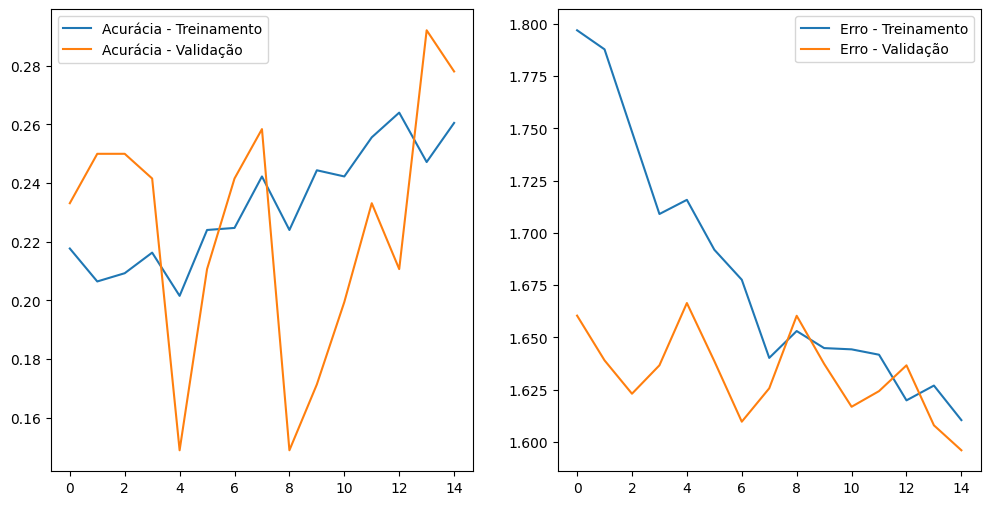

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

sns.lineplot(x=epochs_range, y=acc, ax=ax[0], label='Acurácia - Treinamento')
sns.lineplot(x=epochs_range, y=val_acc, ax=ax[0], label='Acurácia - Validação')

sns.lineplot(x=epochs_range, y=loss, ax=ax[1], label='Erro - Treinamento')
sns.lineplot(x=epochs_range, y=val_loss, ax=ax[1], label='Erro - Validação')


plt.show()

# Rede LSTM + RNN + GRU

LSTM = Long Short Term Memory

Vai ajudar a rede a continuar aprendendo com o andamento do treinamento, evitando o problema do vanishing gradient problem.

Além de testar agora com algumas camadas da LSTM, vamos também acrescentar uma cadama GRU (Gated Recurrent Unit) que também tem o objetivo de abordar algumas das limitações das camadas RNN tradicionais, como o problema do desaparecimento do gradiente. A GRU introduz mecanismos de portão que permitem que a rede aprenda quais informações devem ser lembradas e quais podem ser esquecidas durante o processamento de sequências, bem parecida com a LSTM!

In [44]:
# Definindo seed
tf.random.set_seed(44)

model2 = Sequential()

# Camada embedding utilizando parametros com total de palaras e tamanho máximo de cada palavra
model2.add(Embedding(total_words, 100, input_length=maxlen))

# Camadas bidirecionais. Análise do contexto tanto de frente para trás como de trás para frente. Return sequences -> retorno de sequencias ao invés de um unico vetor
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.2, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.3, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, activation='tanh', return_sequences=True)))

model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))

model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.2, recurrent_regularizer='l1_l2'))

model2.add(Dropout(0.2))
# 5 = 5 variáveis categóricas
model2.add(Dense(5, activation='softmax'))

model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 100)          2275900   
                                                                 
 bidirectional_17 (Bidirect  (None, 200, 128)          84480     
 ional)                                                          
                                                                 
 bidirectional_18 (Bidirect  (None, 200, 128)          98816     
 ional)                                                          
                                                                 
 bidirectional_19 (Bidirect  (None, 200, 128)          24704     
 ional)                                                          
                                                                 
 conv1d_5 (Conv1D)           (None, 198, 72)           27720     
                                                      

In [45]:
# Adam = algoritmo de otimização, loss = função de perda a ser minimizada pelo algoritmo, metrics = métrica para monitorar durante o treinamento
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Config early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Métrica para monitorar early stopping
                                              patience=3,
                                              verbose=1, # Mostra mensagens de progresso durante treinamento
                                              mode='min') # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"

# Salvando modelo com melhores valores encontrados
checkpointer = ModelCheckpoint(filepath='bestbalue', monitor='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# Treinando modelo
history = model2.fit(train_padseq, y_train, batch_size=120, epochs=20, validation_split=0.2)

#Validando modelo
test_loss, test_acc = model2.evaluate(test_padseq, y_test, verbose=0)
print('Test loss and accuracy:',test_loss, test_acc)

Epoch 1/20
12/12 [==============================] - 48s 3s/step - loss: 8.6617 - accuracy: 0.2149 - val_loss: 7.8413 - val_accuracy: 0.2360
Epoch 2/20
12/12 [==============================] - 36s 3s/step - loss: 7.2572 - accuracy: 0.2331 - val_loss: 6.5525 - val_accuracy: 0.1910
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 6.0762 - accuracy: 0.2100 - val_loss: 5.4860 - val_accuracy: 0.2388
Epoch 4/20
12/12 [==============================] - 38s 3s/step - loss: 5.0659 - accuracy: 0.2114 - val_loss: 4.5565 - val_accuracy: 0.2697
Epoch 5/20
12/12 [==============================] - 37s 3s/step - loss: 4.2298 - accuracy: 0.2423 - val_loss: 3.7585 - val_accuracy: 0.3315
Epoch 6/20
12/12 [==============================] - 38s 3s/step - loss: 3.4479 - accuracy: 0.3631 - val_loss: 3.1580 - val_accuracy: 0.4438
Epoch 7/20
12/12 [==============================] - 39s 3s/step - loss: 2.7571 - accuracy: 0.4396 - val_loss: 2.5024 - val_accuracy: 0.4551
Epoch 8/20
12/12 [==

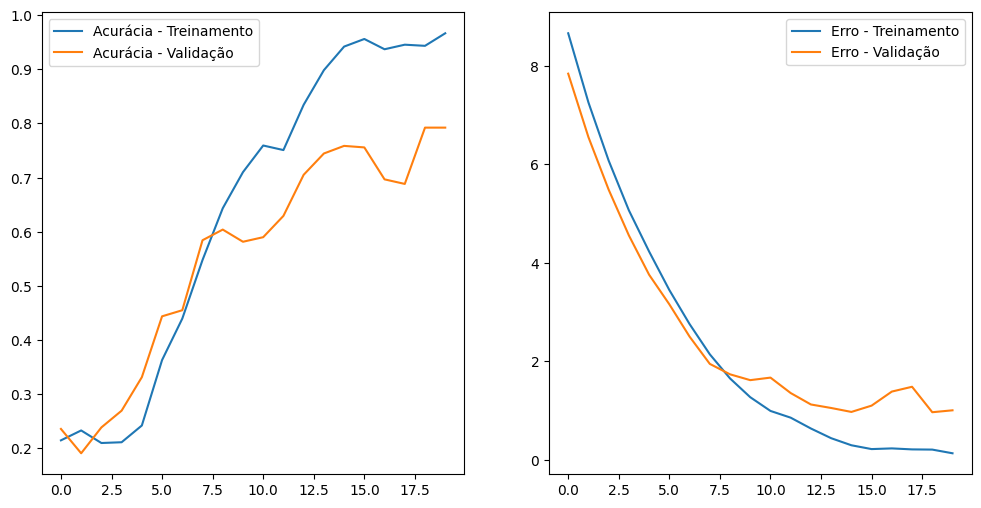

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

sns.lineplot(x=epochs_range, y=acc, ax=ax[0], label='Acurácia - Treinamento')
sns.lineplot(x=epochs_range, y=val_acc, ax=ax[0], label='Acurácia - Validação')

sns.lineplot(x=epochs_range, y=loss, ax=ax[1], label='Erro - Treinamento')
sns.lineplot(x=epochs_range, y=val_loss, ax=ax[1], label='Erro - Validação')


plt.show()

In [49]:
model2.save("model2.h5")

# Teste de classifiação

In [56]:
new_text = 'The coach of the South Korean national soccer team has been fired in the wake of a brawl between star player and captain Son Heung-min and midfielder Lee Kang-in before the team’s disastrous Asian Cup exit. “(Jürgen) Klinsmann has failed to show his competence in managing the game, the players, along with the expected attitudes as a South Korean coach,” Chung Mong-gyu, chairman of the Korean Football Association (KFA) said announcing Klinsmann’s ouster on Friday.'
new_text_norm = limpeza_texto(new_text)

print(new_text_norm)

coach south korean national soccer team fire wake brawl star player captain son heungmin midfielder lee kangin team disastrous asian cup exit jürgen klinsmann fail show competence manage game players along expect attitudes south korean coach chung monggyu chairman korean football association kfa say announce klinsmanns ouster friday


In [57]:
new_sequence = tokenizer.texts_to_sequences([new_text_norm])
print(new_sequence)

new_sequence = pad_sequences(new_sequence, maxlen=maxlen)
print(new_sequence)

[[351, 379, 1, 259, 1, 151, 1, 1, 1, 113, 295, 884, 1, 1, 1, 1, 1, 151, 1, 1, 308, 1, 1, 1, 318, 28, 1, 679, 15, 128, 1, 66, 1, 379, 1, 351, 1, 1, 500, 1, 554, 634, 1, 3, 221, 1, 1, 526]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 351 379   1 259   1 151   1   1   1 113
  295 884   1   1   1   1   1 151   1   1 308   1   1   1 318  28   1 679
   15 128   1  66   1 379   1 351   1   1 500   1 554 634   1   3 221   

In [58]:
predictions = model2.predict(new_sequence)
print(predictions)

1/1 [==============================] - 0s 148ms/step
[[4.1660969e-05 7.9540052e-03 1.1368189e-03 9.9069864e-01 1.6894445e-04]]


In [59]:
class_names = ['bussiness - 0', 'entertainment - 1', 'politics - 2', 'sports - 3', 'tech - 4']

In [60]:
predict_class = np.argmax(predictions)
predict_cass_name = class_names[predict_class]

print(predict_cass_name)

sports - 3
